In [15]:
import pandas
from numpy import round_
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import relabeling_pydl
import math
import ast
from tqdm.notebook import tqdm

In [16]:
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
FILE_NAME = "lawsuit_k_supp2_relab"

In [17]:
import load_data
X, y, sensitive = load_data.lawsuit()
print(utils.discrimination(y, sensitive))
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

0.31205112598904444


In [18]:
result = pandas.read_csv("save/lawsuit_k_supp2.csv")
#result
threshold_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [19]:

for leaf_limit in range (1, 4):
    result['accuracy_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_abs_'+str(leaf_limit)] = np.nan
    result['accuracy_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_abs_'+str(leaf_limit)] = np.nan

for threshold in threshold_list:
    result['accuracy_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_abs_'+str(threshold)] = np.nan
    result['accuracy_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_abs_'+str(threshold)] = np.nan

In [20]:
def round_down(a):
    return math.floor(a * 100000)/100000.0
clf = DL85Classifier(max_depth=1, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=2, time_limit=600)
clf.fit(X_train)

run = False
if run:
    for leaf_limit in range (1, 4):
        for index, row in tqdm(result.iterrows(), total=result.shape[0]):
            #if (index in [1551, 1573, 1591, 1595, 1596, 1597] or index < 1900) and False:
            #    continue
            random_state = result.at[index, 'random_state']
            accuracy_train = result.at[index, 'accuracy_pred']
            discrimination_train_pred = result.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(result.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling_pydl.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, leaf_limit)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc

            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train))
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            result.at[index, 'accuracy_relab_'+str(leaf_limit)] = accuracy_train_relab
            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            result.at[index, 'discrimination_relab_'+str(leaf_limit)] = sum_discri_
            result.at[index, 'discrimination_relab_abs_'+str(leaf_limit)] = sum_discri_abs_

            y_pred_test_relab = clf.predict(X_test)
            discri_test= list()
            utils.get_discri_test(clf.tree_, X_test, y_pred_test_relab, sensitive_test, discri_test, X.columns, path=None)
            sum_discrimination_additive_test_pred = sum(discri_test)
            sum_discrimination_additive_test_pred_abs = 0
            [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

            result.at[index, 'accuracy_relab_test_'+str(leaf_limit)] = round_down(accuracy_score(y_test, y_pred_test_relab))
            result.at[index, 'discrimination_relab_test_'+str(leaf_limit)] = sum_discrimination_additive_test_pred
            result.at[index, 'discrimination_relab_test_abs_'+str(leaf_limit)] = sum_discrimination_additive_test_pred_abs


            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not (round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(result.iloc[index])
                print(f"{relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train)}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))

                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))
        result.to_csv('save/'+FILE_NAME+'.csv', index=False)

In [21]:
if run:
    for threshold in threshold_list:
        for index, row in tqdm(result.iterrows(), total=result.shape[0]):

            random_state = result.at[index, 'random_state']
            accuracy_train = result.at[index, 'accuracy_pred']
            discrimination_train_pred = result.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(result.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, threshold)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc

            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train))
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            result.at[index, 'accuracy_relab_'+str(threshold)] = accuracy_train_relab
            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            result.at[index, 'discrimination_relab_'+str(threshold)] = sum_discri_
            result.at[index, 'discrimination_relab_abs_'+str(threshold)] = sum_discri_abs_

            y_pred_test_relab = clf.predict(X_test)
            discri_test= list()
            utils.get_discri_test(clf.tree_, X_test, y_pred_test_relab, sensitive_test, discri_test, X.columns, path=None)
            sum_discrimination_additive_test_pred = sum(discri_test)
            sum_discrimination_additive_test_pred_abs = 0
            [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

            result.at[index, 'accuracy_relab_test_'+str(threshold)] = round_down(accuracy_score(y_test, y_pred_test_relab))
            result.at[index, 'discrimination_relab_test_'+str(threshold)] = sum_discrimination_additive_test_pred
            result.at[index, 'discrimination_relab_test_abs_'+str(threshold)] = sum_discrimination_additive_test_pred_abs

            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not ( discrimation_train_pred_relab <= threshold or round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(result.iloc[index])
                print(f"{discrimation_train_pred_relab}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))
                assert(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train) <= threshold)
                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))

        result.to_csv('save/'+FILE_NAME+'.csv', index=False)

In [22]:
result = pandas.read_csv('save/'+FILE_NAME+'.csv')
result

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,discrimination_relab_abs_0.25,accuracy_relab_test_0.25,discrimination_relab_test_0.25,discrimination_relab_test_abs_0.25,accuracy_relab_0.3,discrimination_relab_0.3,discrimination_relab_abs_0.3,accuracy_relab_test_0.3,discrimination_relab_test_0.3,discrimination_relab_test_abs_0.3
0,0,1,1,51.000000,0.755981,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
1,5,1,1,52.628094,0.748191,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
2,10,1,1,54.256191,0.740401,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
3,50,1,1,67.280952,0.678082,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
4,100,1,1,83.561905,0.600182,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,200,7,99,89.074608,0.573806,"((59, 4, 6, 53), (14, 6, 1, 66))",0.918660,0.826923,17,0.360373,...,0.37846,0.80769,0.094099,0.208931,0.91866,0.28650,0.28650,0.82692,0.063796,0.178628
3846,250,7,99,107.093262,0.487592,"((59, 4, 6, 53), (14, 6, 1, 66))",0.918660,0.826923,17,0.360373,...,0.40145,0.80769,0.094099,0.208931,0.91866,0.28650,0.28650,0.82692,0.063796,0.178628
3847,500,7,99,197.186523,0.056524,"((59, 4, 6, 53), (14, 6, 1, 66))",0.918660,0.826923,17,0.360373,...,0.40145,0.80769,0.094099,0.208931,0.91866,0.28650,0.28650,0.82692,0.063796,0.178628
3848,1000,7,99,377.373047,-0.805613,"((59, 4, 6, 53), (14, 6, 1, 66))",0.918660,0.826923,17,0.360373,...,0.40145,0.80769,0.094099,0.208931,0.91866,0.28650,0.28650,0.82692,0.063796,0.178628


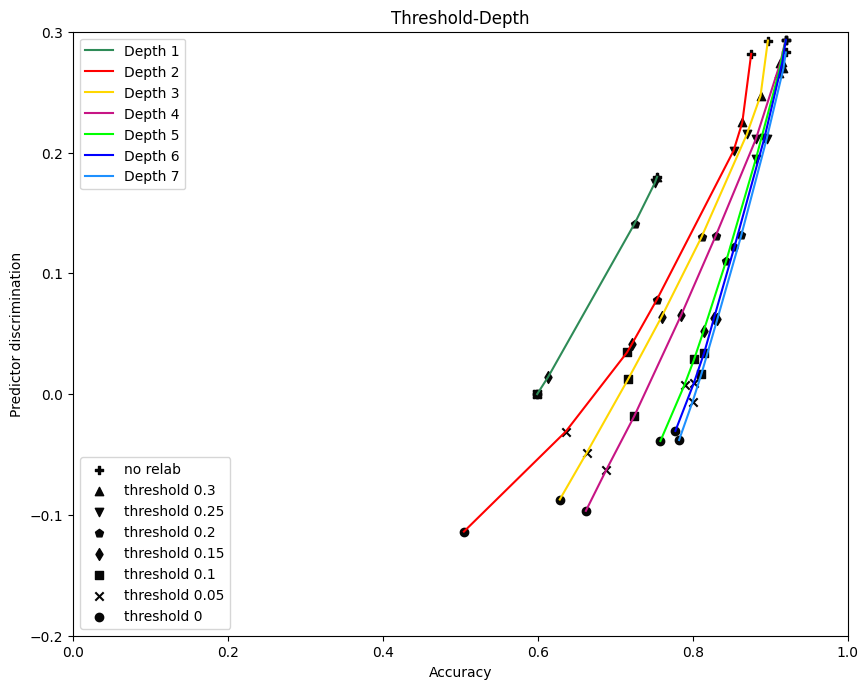

In [23]:
_COLORS4 = ['#ff0000', '#00ff00', '#0000ff', '#87cefa']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS7 = ['#2e8b57', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#0000ff', '#1e90ff']
_COLORS10 = ['#006400', '#00008b', '#b03060', '#ff4500', '#ffd700', '#7cfc00', '#00ffff', '#ff00ff', '#6495ed',
          '#ffdab9']
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
             '#ff1493', '#ffe4c4']
colors = _COLORS7.copy()

legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', 'v', '^', 'P']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=0
done = False
list_point = list()
for depth in result['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.05', 'discrimination_relab_0.05'), 
                         ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.15', 'discrimination_relab_0.15'), 
                         ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.25', 'discrimination_relab_0.25'), 
                         ('accuracy_relab_0.3', 'discrimination_relab_0.3'), 
                         ('accuracy_pred', 'discrimination_train_pred')]:

        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        if done == False:
            list_point.append(plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c='#060606', marker=markers[index_marker]))
            
        else:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c='#060606', marker=markers[index_marker])
        index_marker +=1
    done = True

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])   
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Threshold-Depth')
plt.ylabel('Predictor discrimination')
plt.xlabel('Accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)

l1 = plt.legend()
plt.legend(reversed(list_point), ['no relab', 'threshold 0.3', 'threshold 0.25', 'threshold 0.2', 'threshold 0.15', 'threshold 0.1', 'threshold 0.05', 'threshold 0'], loc='lower left', scatterpoints=1)
plt.gca().add_artist(l1)
plt.savefig('plots/relabeling_graph_dl.svg',dpi=350)
plt.show()

In [24]:
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
             '#ff1493', '#ffe4c4']
_COLORS4 = ['#ff0000', '#00ff00', '#0000ff', '#87cefa']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS7 = ['#2e8b57', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#0000ff', '#1e90ff']
_COLORS10 = ['#006400', '#00008b', '#b03060', '#ff4500', '#ffd700', '#7cfc00', '#00ffff', '#ff00ff', '#6495ed',
          '#ffdab9']

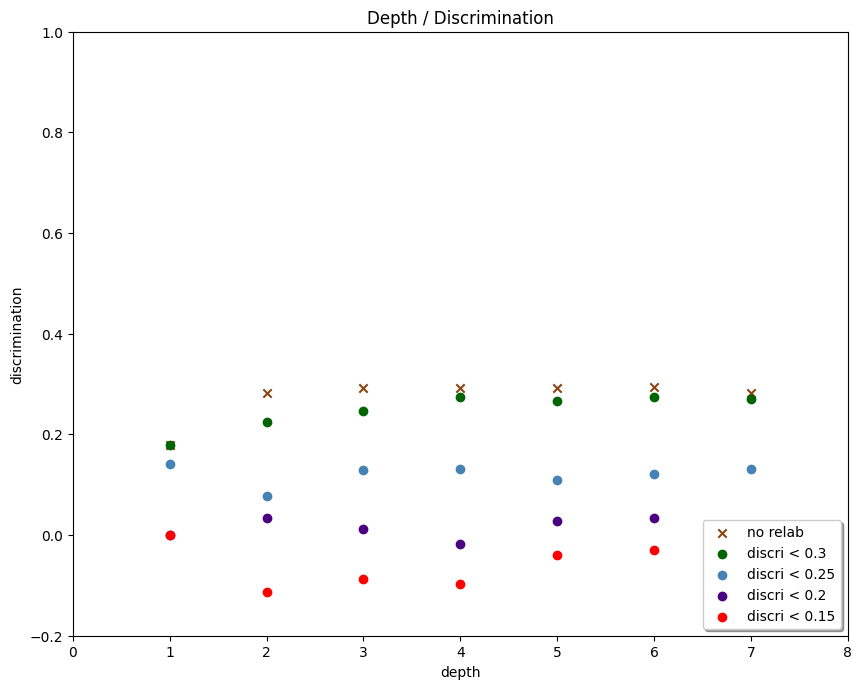

In [25]:
def graphh(axe1, axe2, x_size, y_size):
    colors11 = _COLORS11.copy()
    colors5 = _COLORS11.copy()
    colors4 = _COLORS5.copy()
    legends = ['discri < 0', 'discri < 0.05', 'discri < 0.1', 'discri < 0.15', 'discri < 0.2', 'discri < 0.25','discri < 0.3', 'no relab']
    legends.reverse()
    fig, axes = plt.subplots()
    index_legends = 0
    for x_axe, y_axe in axe1:
        
        y_values_pydl = list()
        x_values_pydl = list()
        isLegend = True
        for depth in result['depth'].unique():
            tmp = result.loc[(result["k"] == 0) & (result["depth"] == depth)]
            y_values_pydl.append(tmp[y_axe].mean())

            if isLegend:
                if index_legends == 0:
                    plt.scatter(depth, tmp[y_axe].mean(), label=legends[index_legends], c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[y_axe].mean(), label=legends[index_legends], c=colors5[index_legends])
            else:
                if index_legends == 0:
                    plt.scatter(depth, tmp[y_axe].mean(), c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[y_axe].mean(), c=colors5[index_legends])
            isLegend = False
        index_legends +=1
    #plt.plot(result['depth'].unique(), y_values_pydl, label="Pydl (relab)", c=colors4[1])

        
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth / Discrimination')
    plt.ylabel('discrimination')
    plt.xlabel('depth')
    plt.ylim(y_size[0], y_size[1])
    plt.xlim(x_size[0], x_size[1])
    plt.legend(loc='lower right', shadow=True)

    plt.show()
graphh([('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.0', 'discrimination_relab_0.0')], ("accuracy_pred", "sum_discrimination_additive_train_pred"), (0, 8), (-0.2, 1))

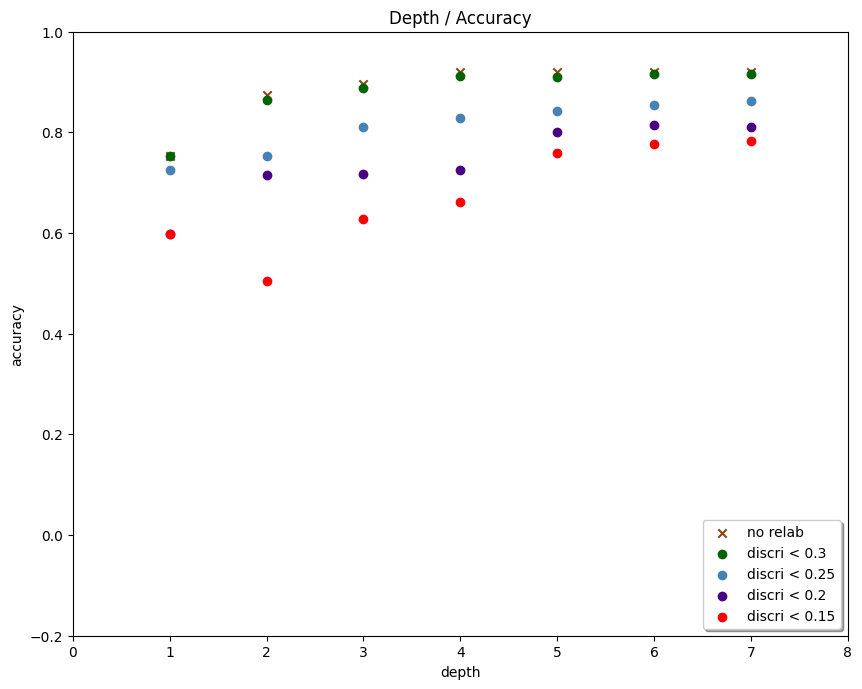

In [26]:
def graphh(axe1, axe2, x_size, y_size):
    colors11 = _COLORS11.copy()
    colors5 = _COLORS11.copy()
    colors4 = _COLORS5.copy()
    legends = ['discri < 0', 'discri < 0.05', 'discri < 0.1', 'discri < 0.15', 'discri < 0.2', 'discri < 0.25','discri < 0.3', 'no relab']
    legends.reverse()
    fig, axes = plt.subplots()
    index_legends = 0
    for x_axe, y_axe in axe1:
        
        y_values_pydl = list()
        x_values_pydl = list()
        isLegend = True
        for depth in result['depth'].unique():
            tmp = result.loc[(result["k"] == 0) & (result["depth"] == depth)]
            y_values_pydl.append(tmp[y_axe].mean())

            if isLegend:
                if index_legends == 0:
                    plt.scatter(depth, tmp[x_axe].mean(), label=legends[index_legends], c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[x_axe].mean(), label=legends[index_legends], c=colors5[index_legends])
            else:
                if index_legends == 0:
                    plt.scatter(depth, tmp[x_axe].mean(), c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[x_axe].mean(), c=colors5[index_legends])
            isLegend = False
        index_legends +=1
    #plt.plot(result['depth'].unique(), y_values_pydl, label="Pydl (relab)", c=colors4[1])

        
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth / Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('depth')
    plt.ylim(y_size[0], y_size[1])
    plt.xlim(x_size[0], x_size[1])
    plt.legend(loc='lower right', shadow=True)

    plt.show()
graphh([('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.0', 'discrimination_relab_0.0')], ("accuracy_pred", "sum_discrimination_additive_train_pred"), (0, 8), (-0.2, 1))

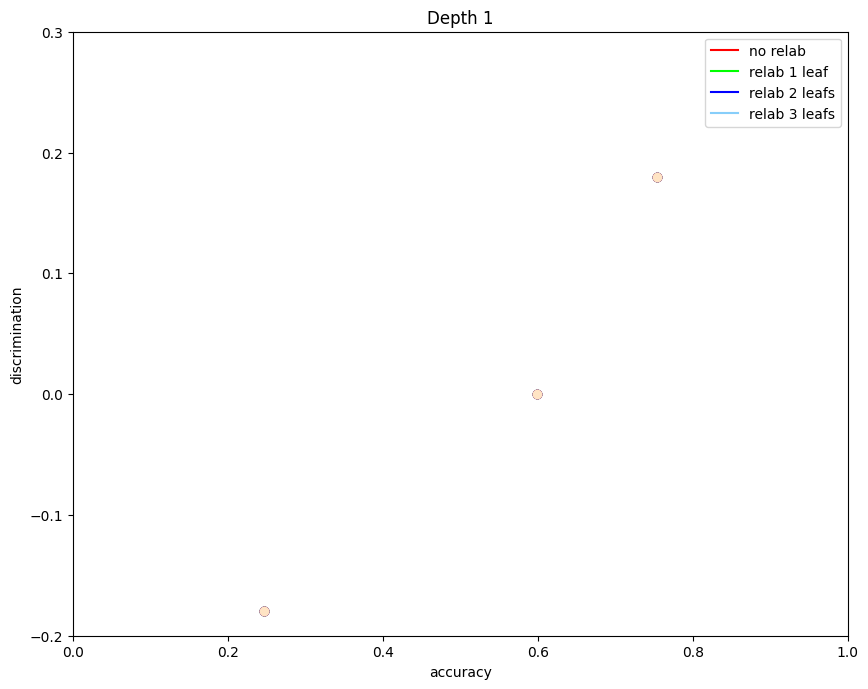

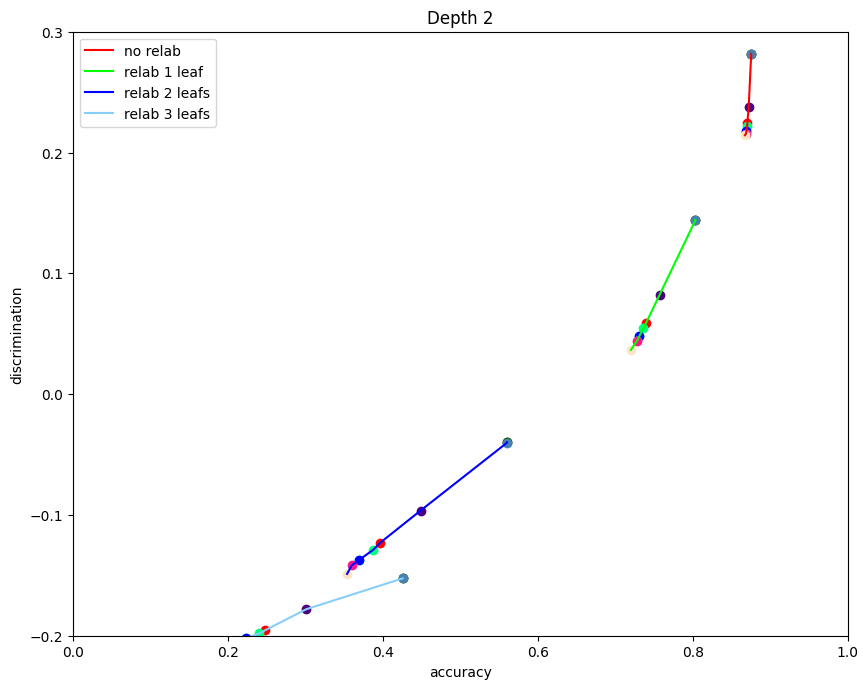

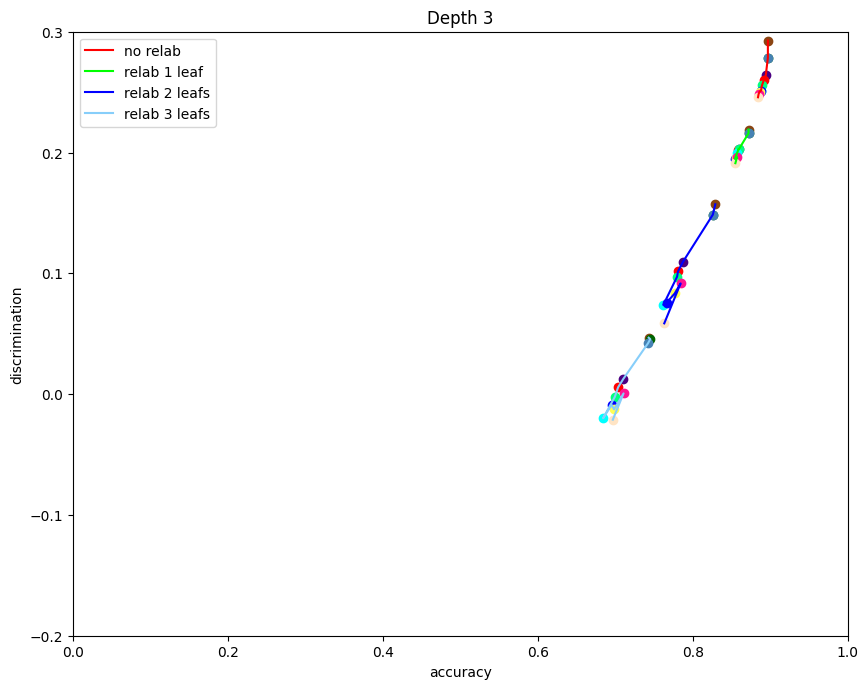

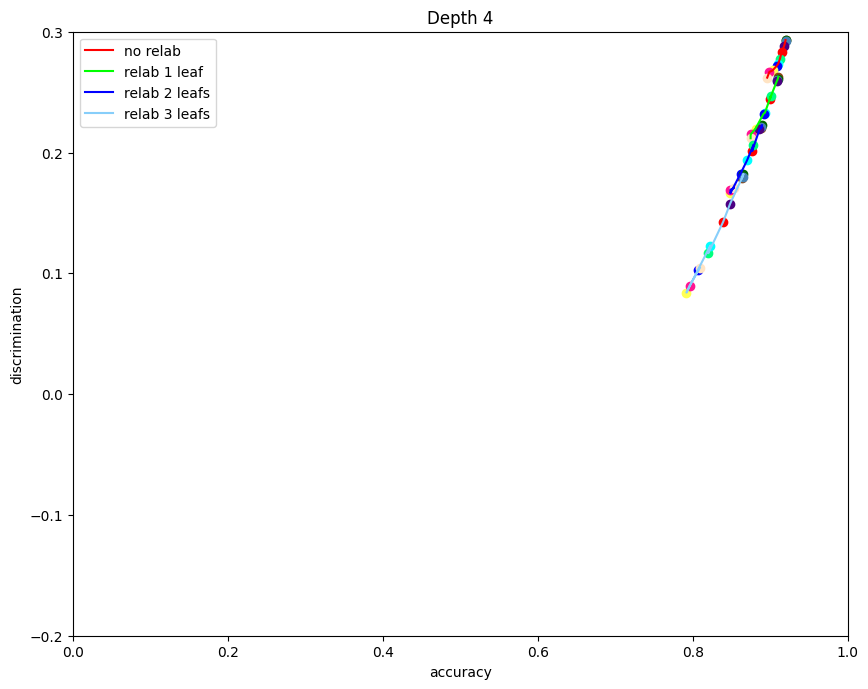

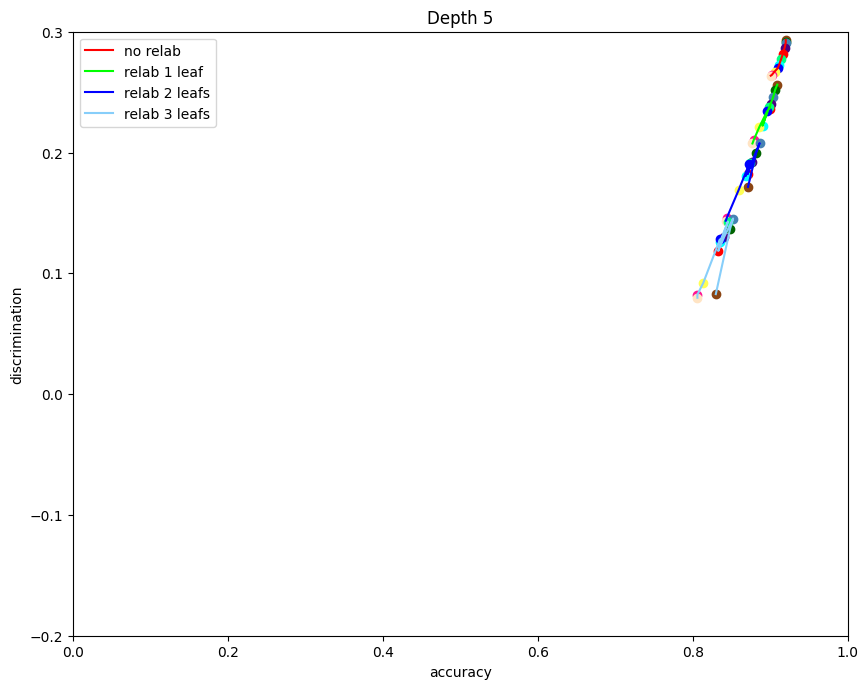

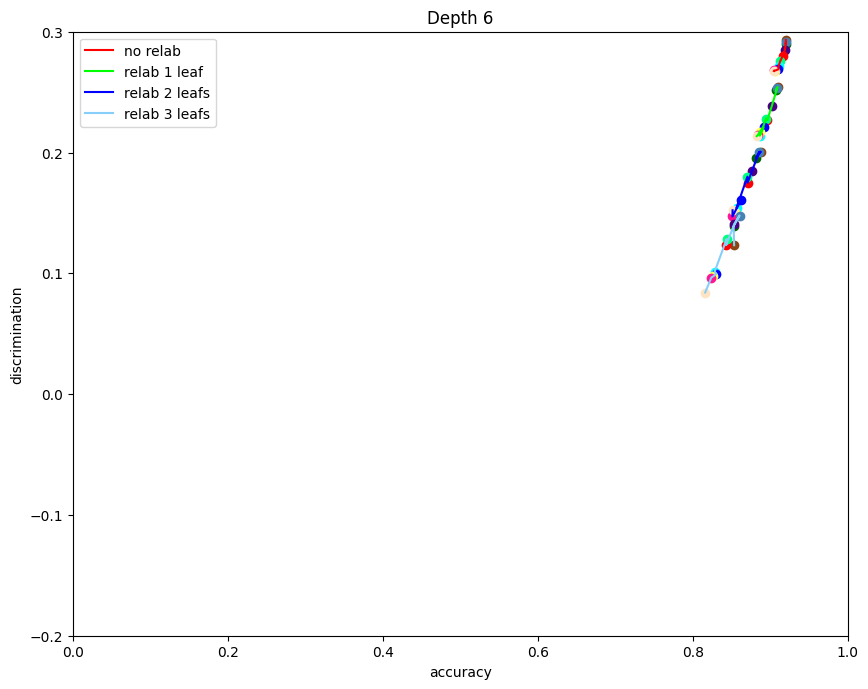

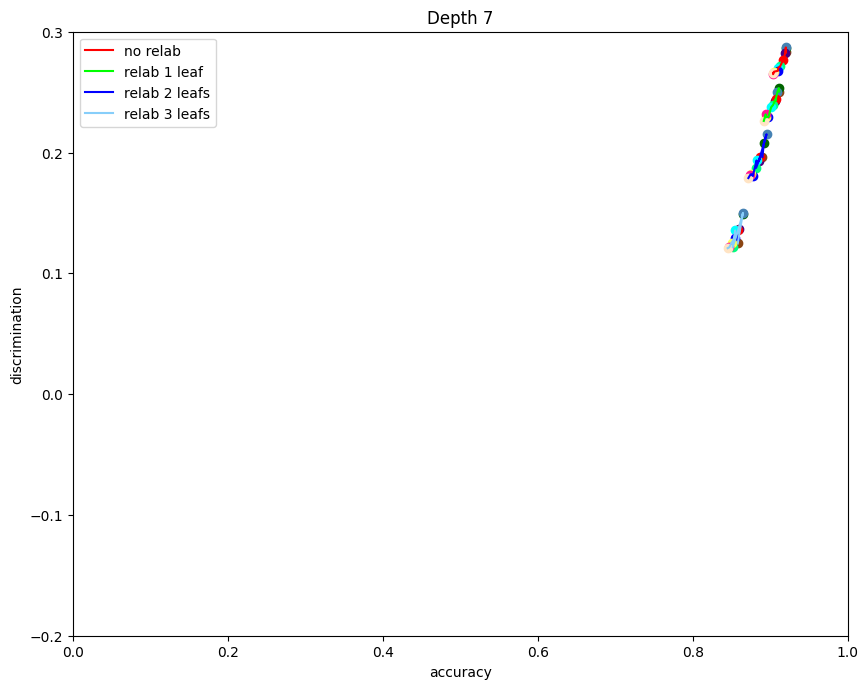

In [27]:
legends = ['no relab', 'relab 1 leaf', 'relab 2 leafs', 'relab 3 leafs']
fig, axes = plt.subplots()
colors11 = _COLORS11.copy()
colors4 = _COLORS4.copy()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

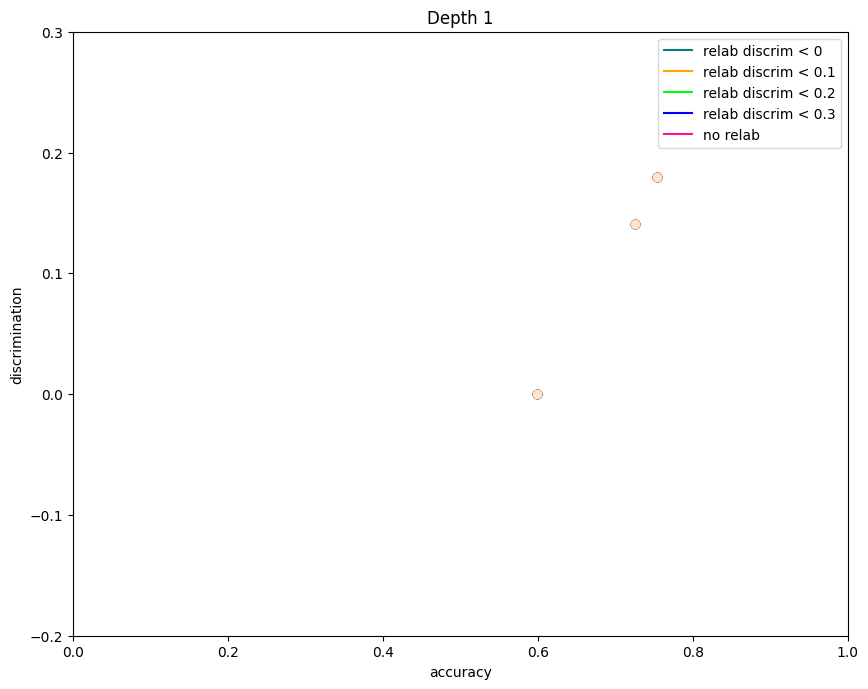

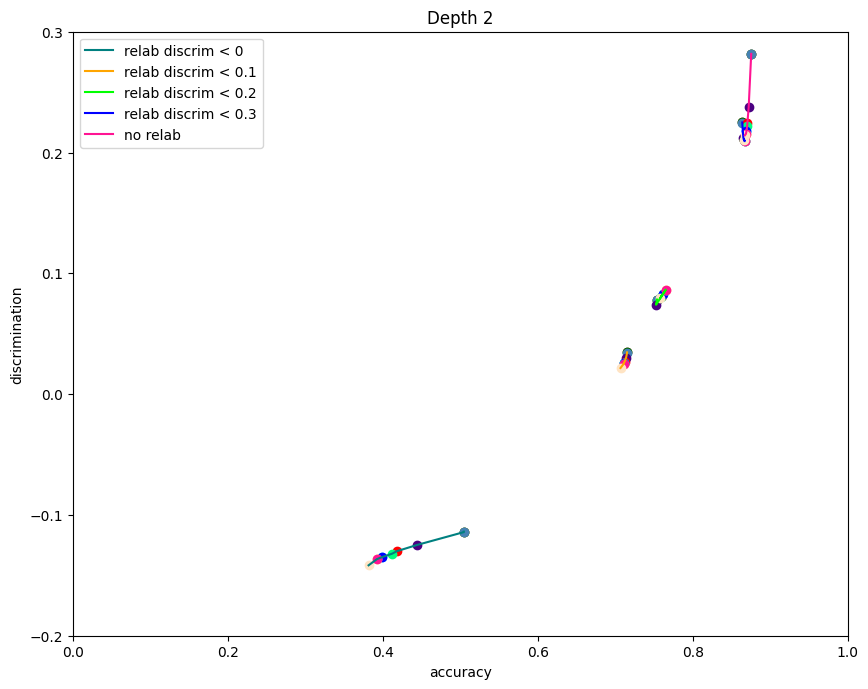

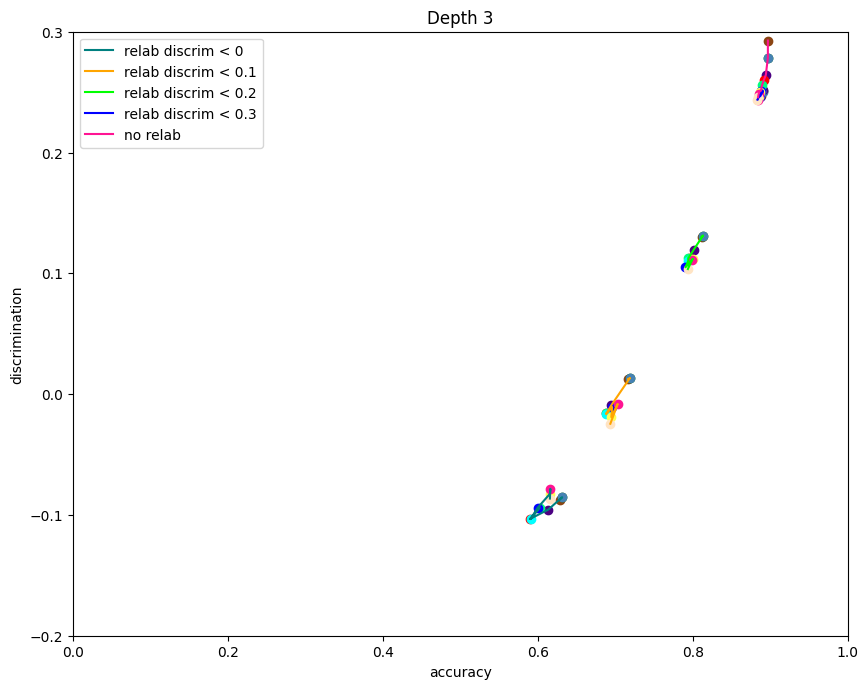

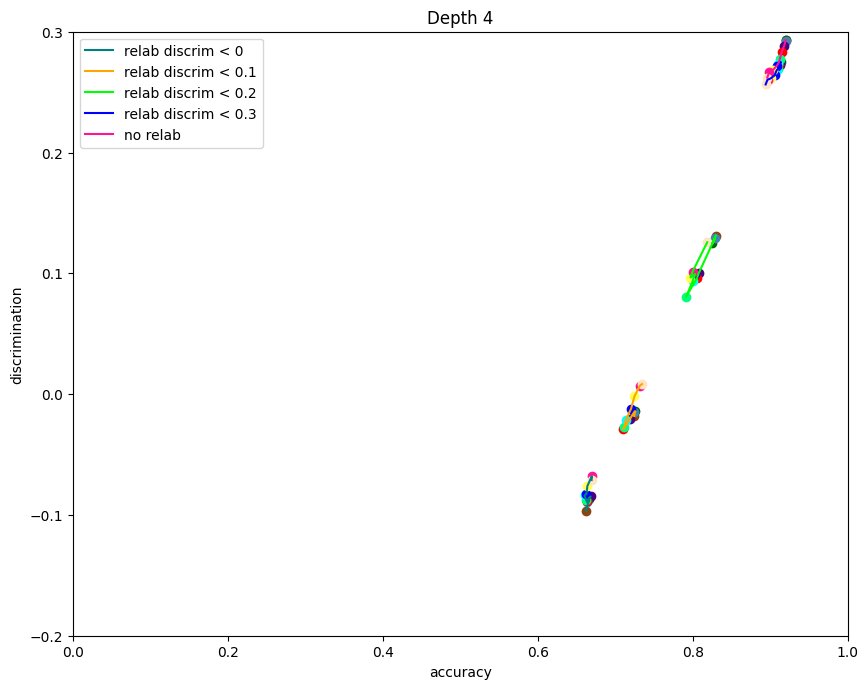

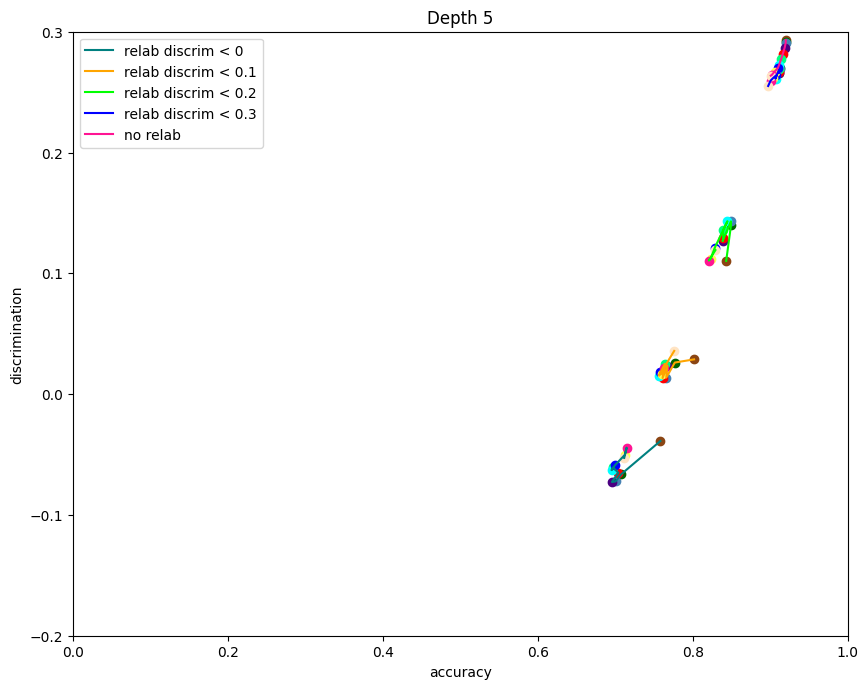

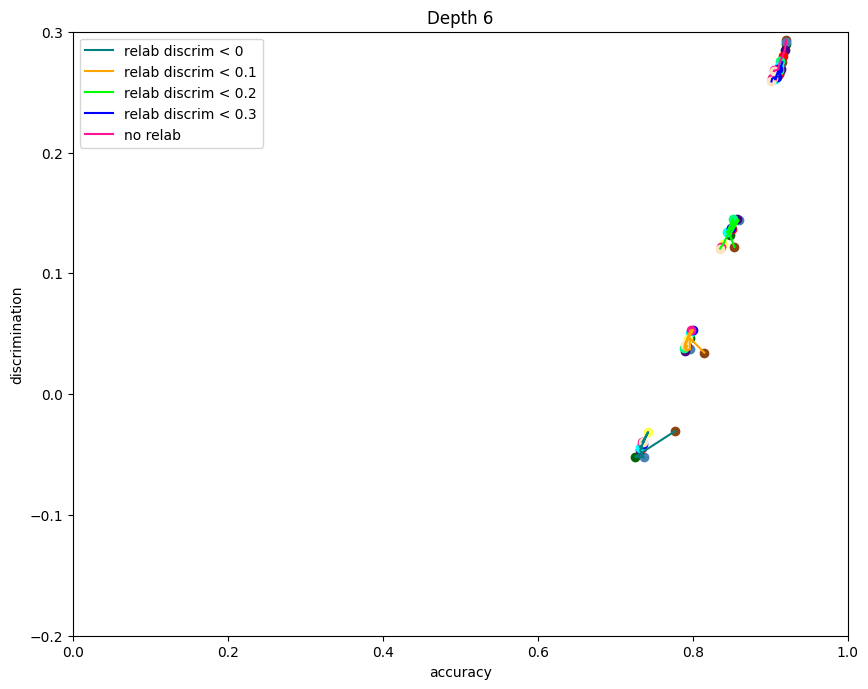

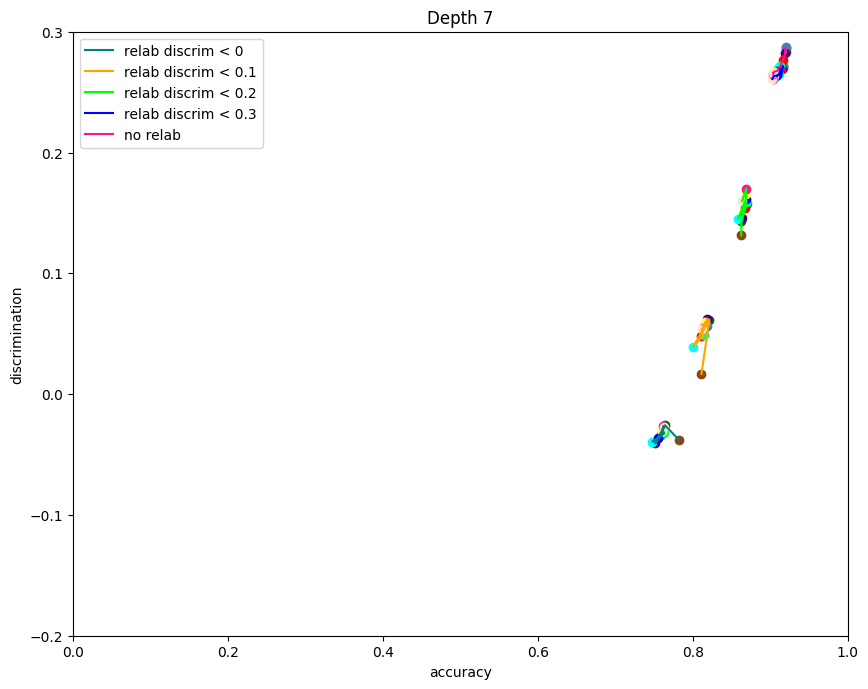

In [28]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'discrimination_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

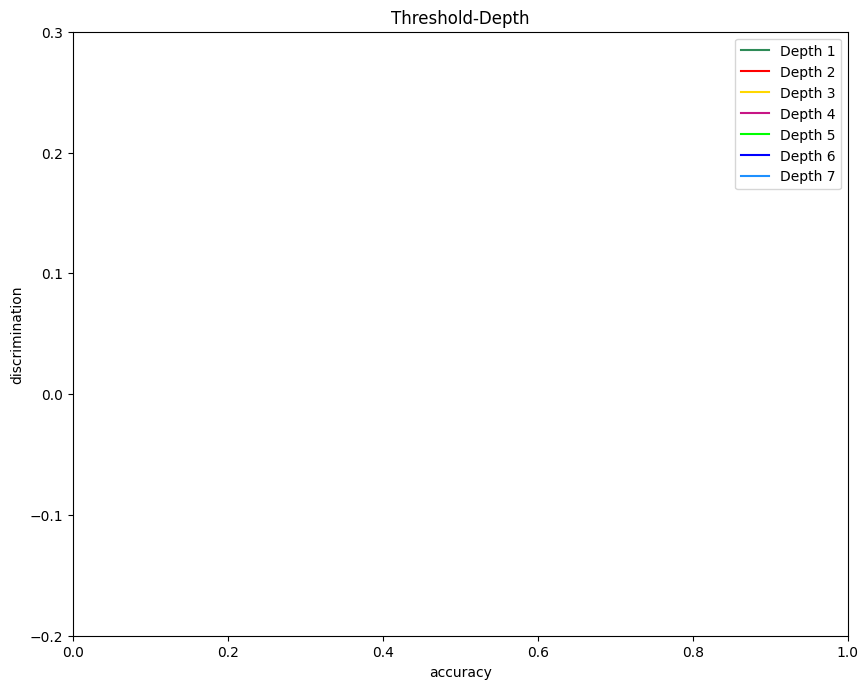

In [29]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in result['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'discrimination_train_pred')]:

        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Threshold-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

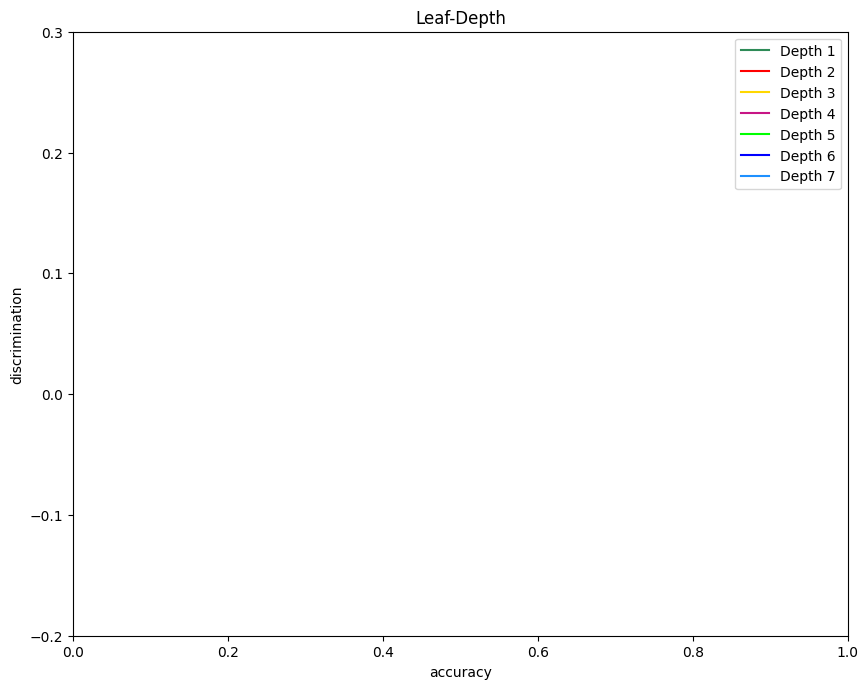

In [30]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in result['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:

        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Leaf-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

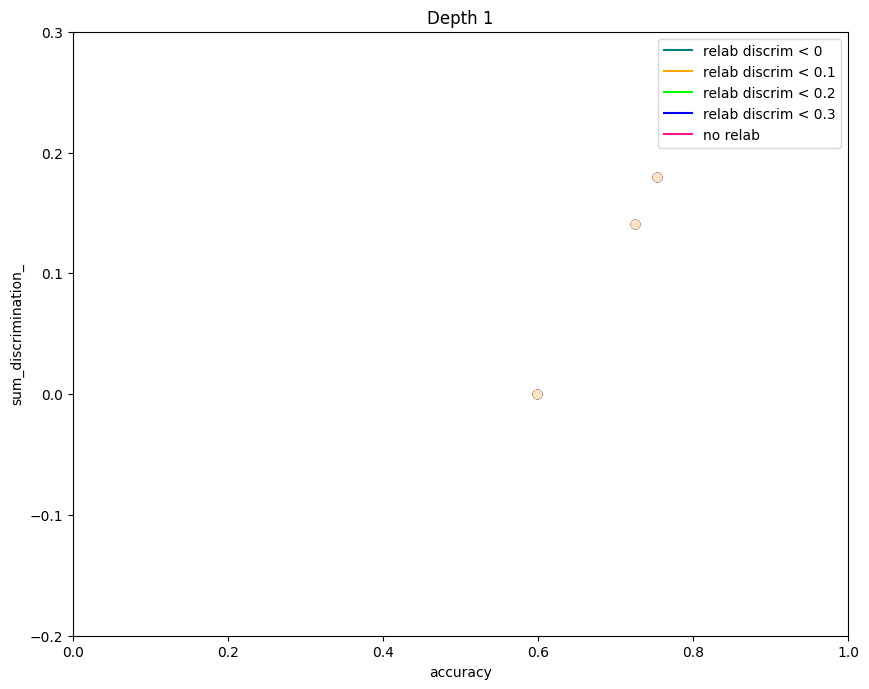

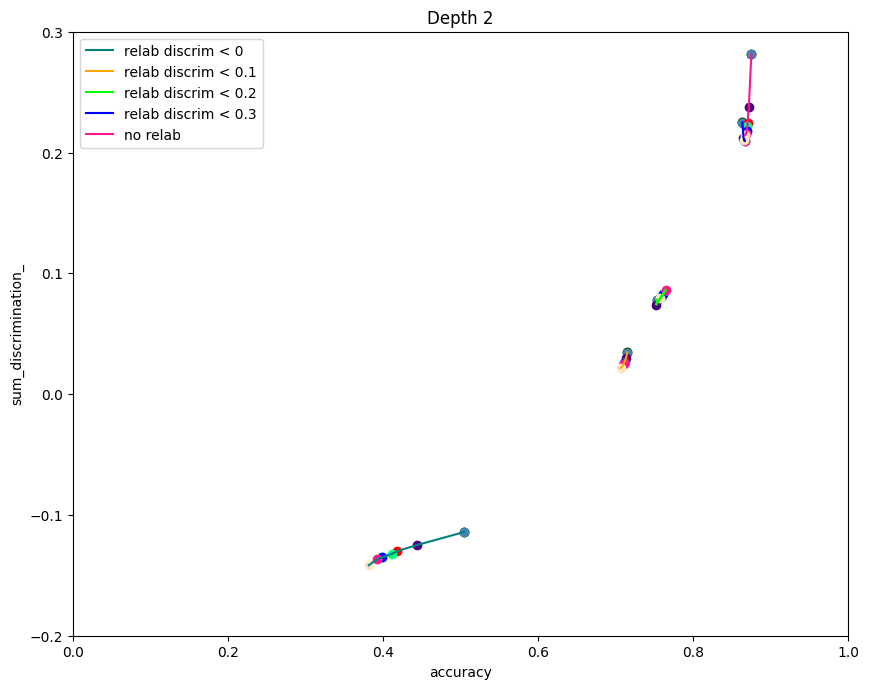

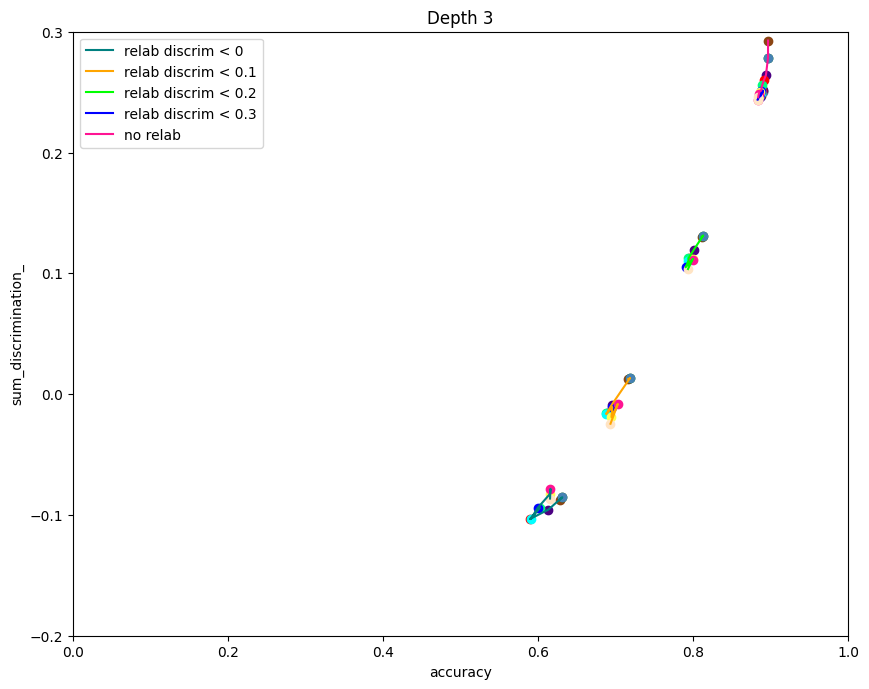

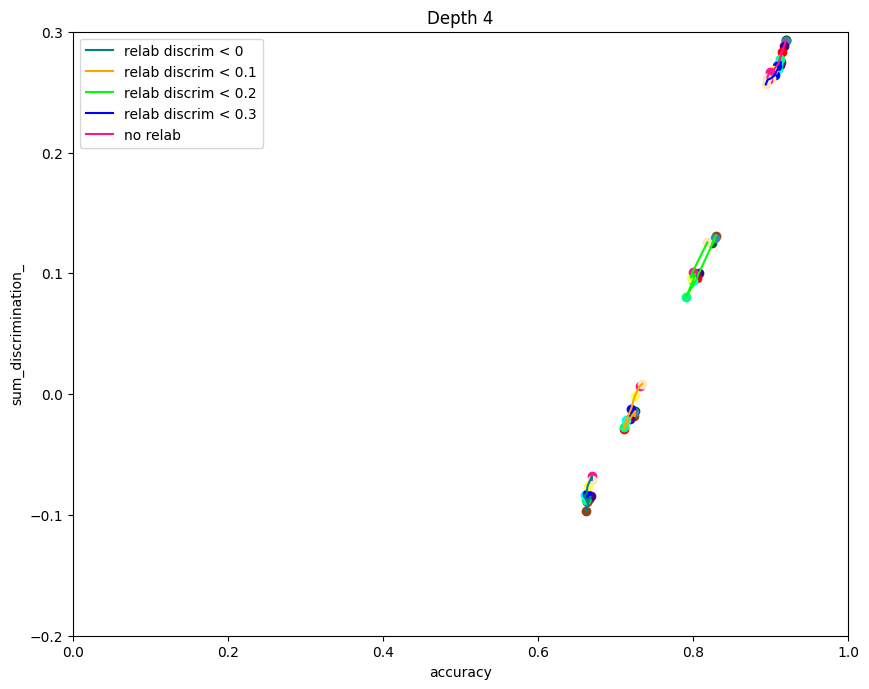

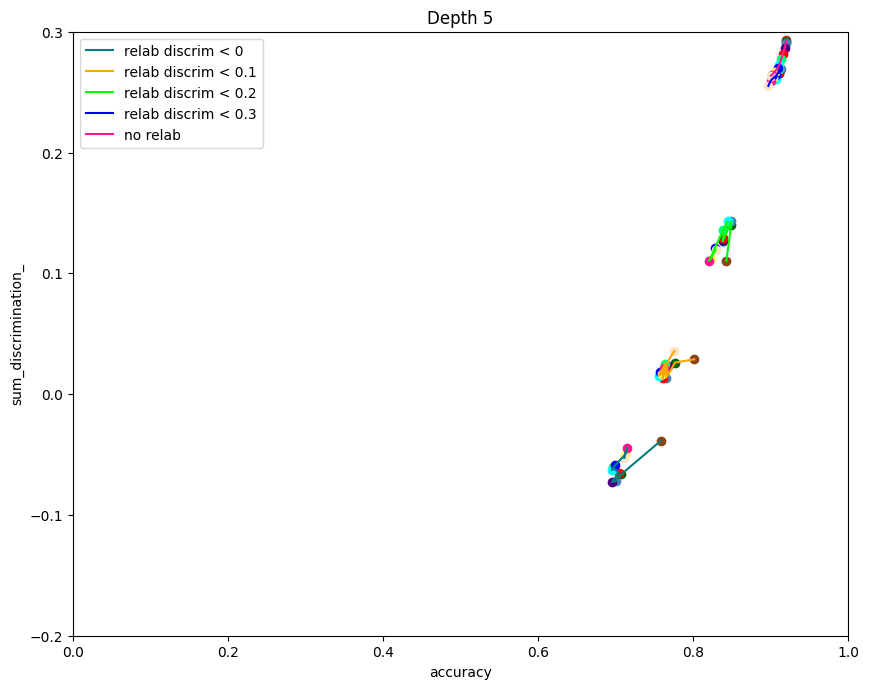

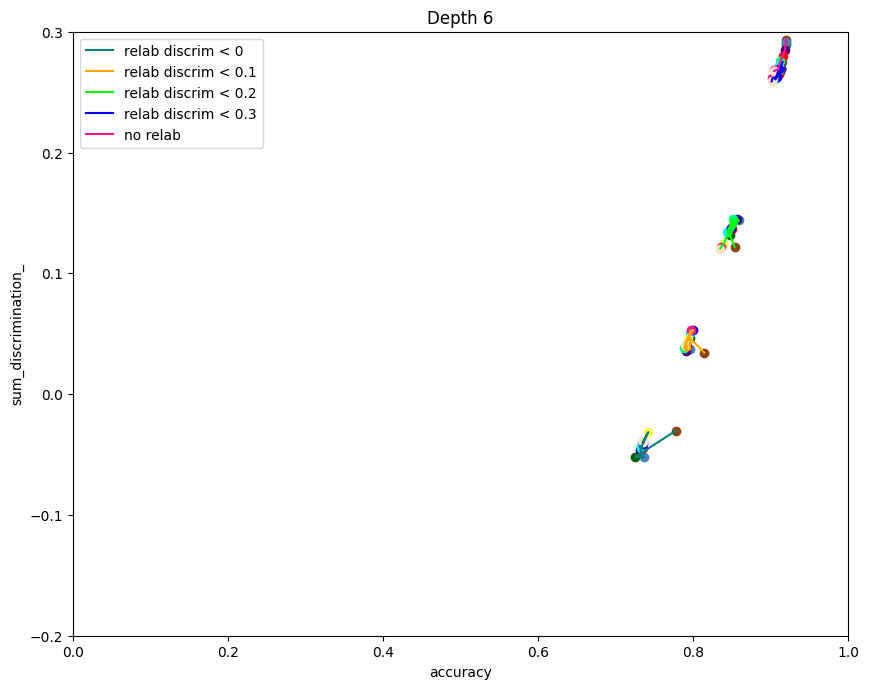

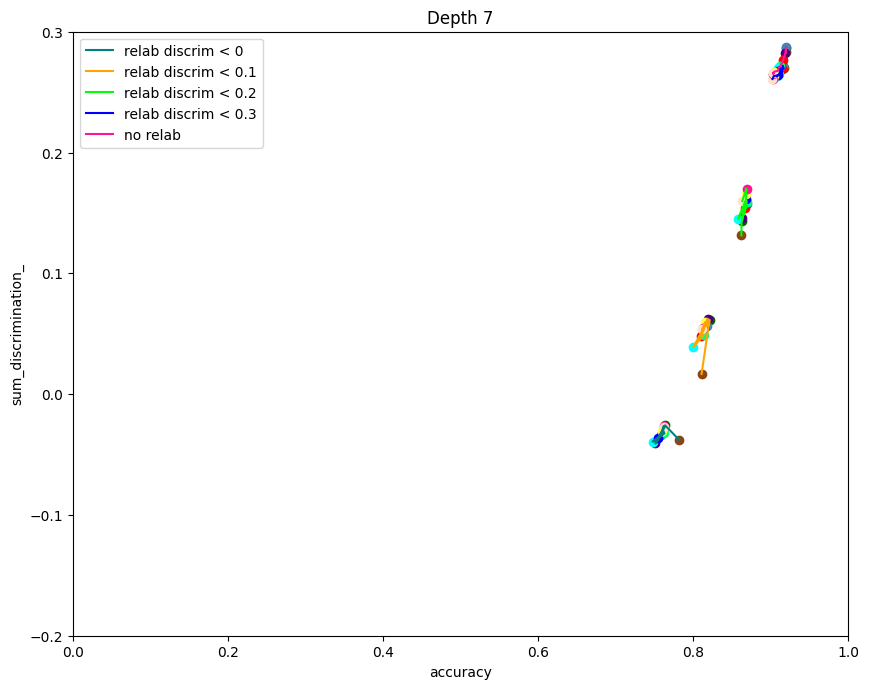

In [31]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'sum_discrimination_additive_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

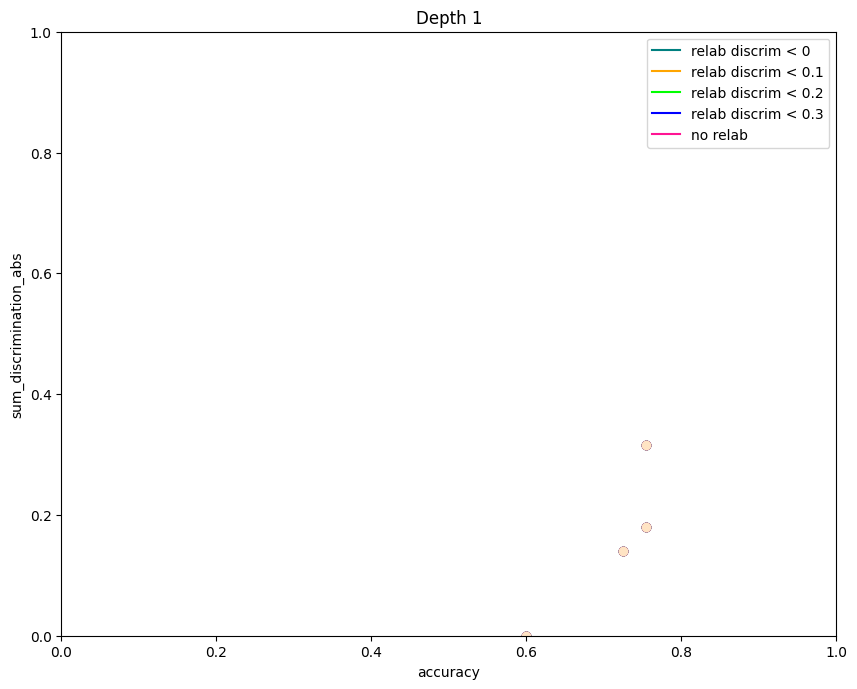

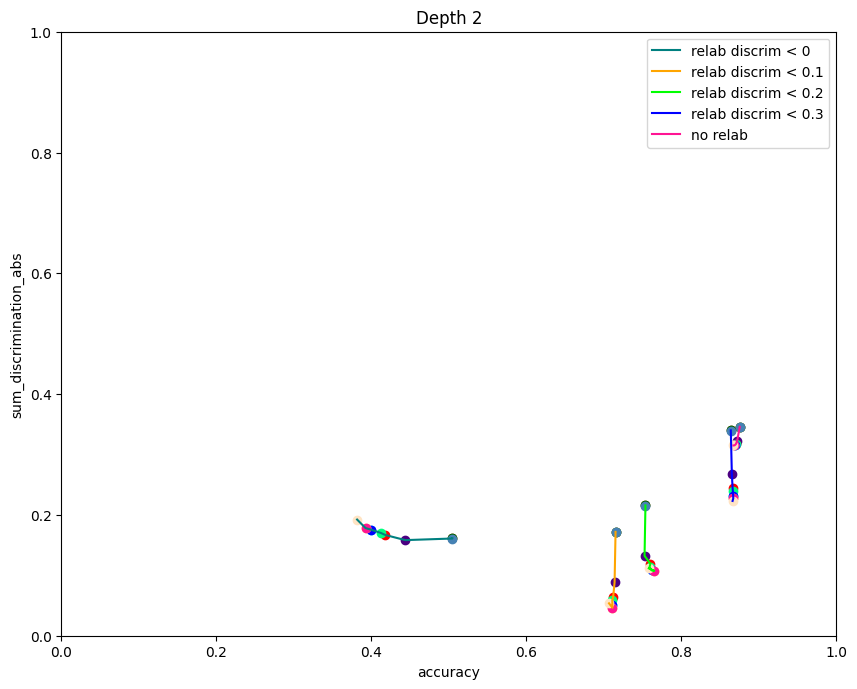

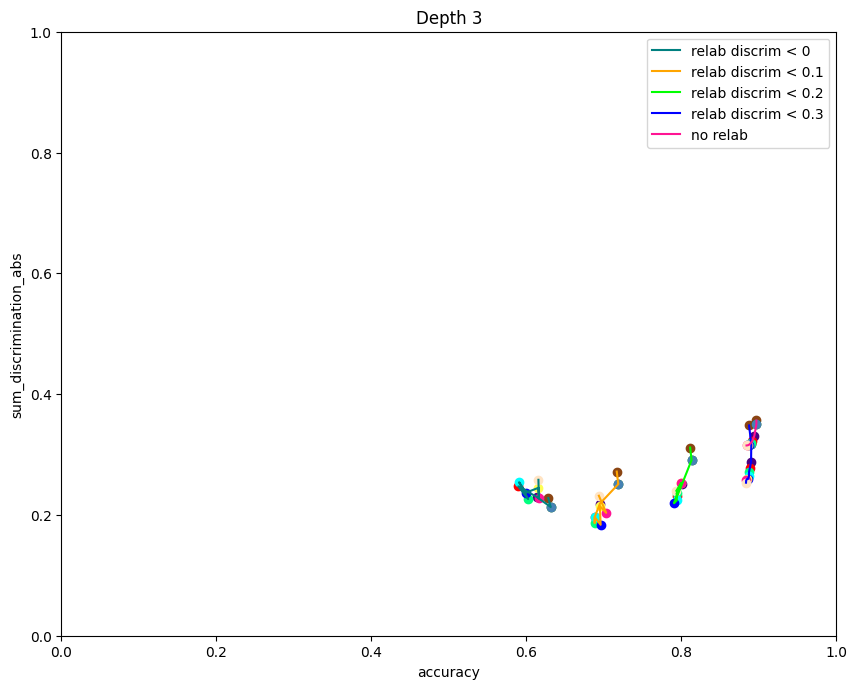

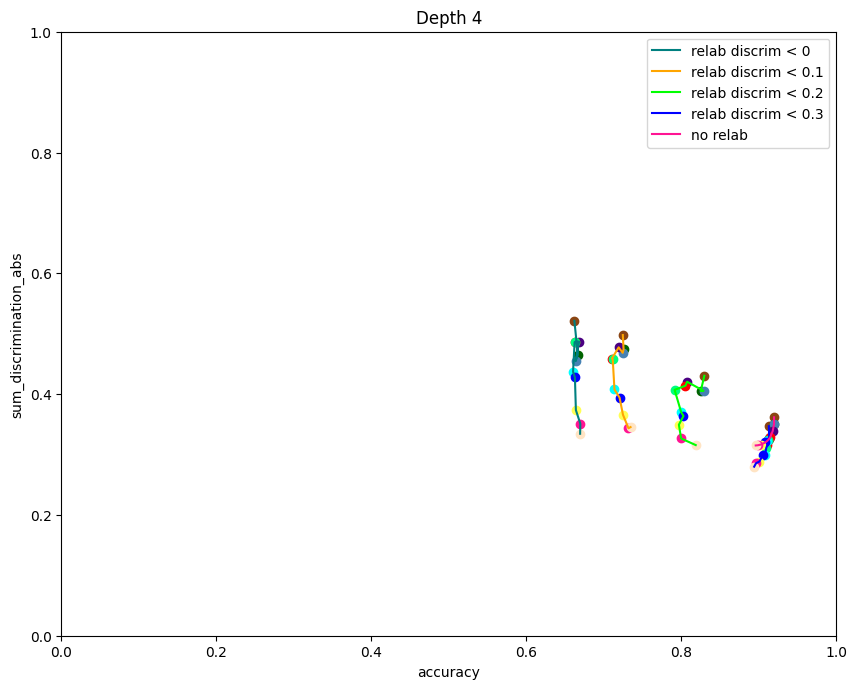

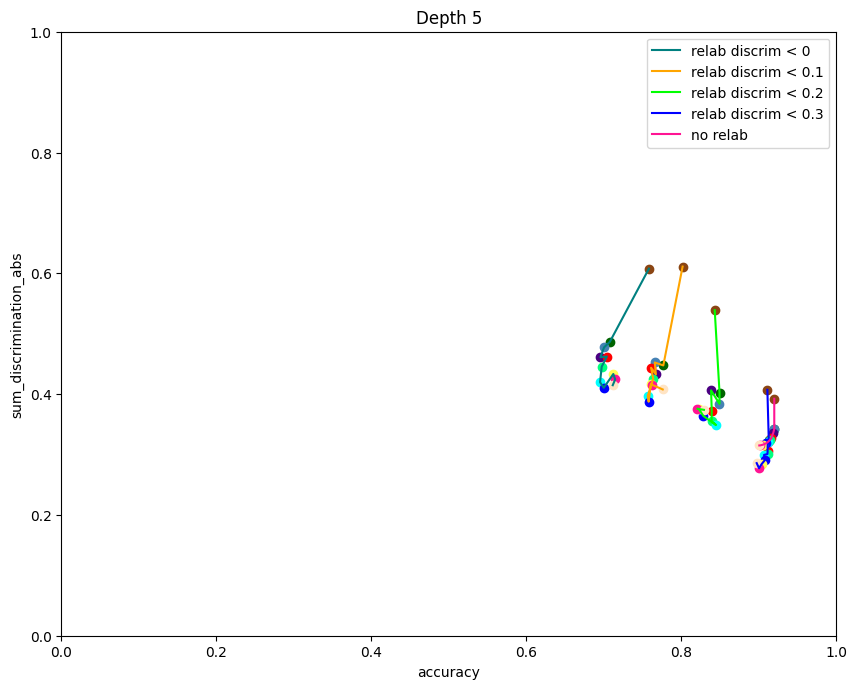

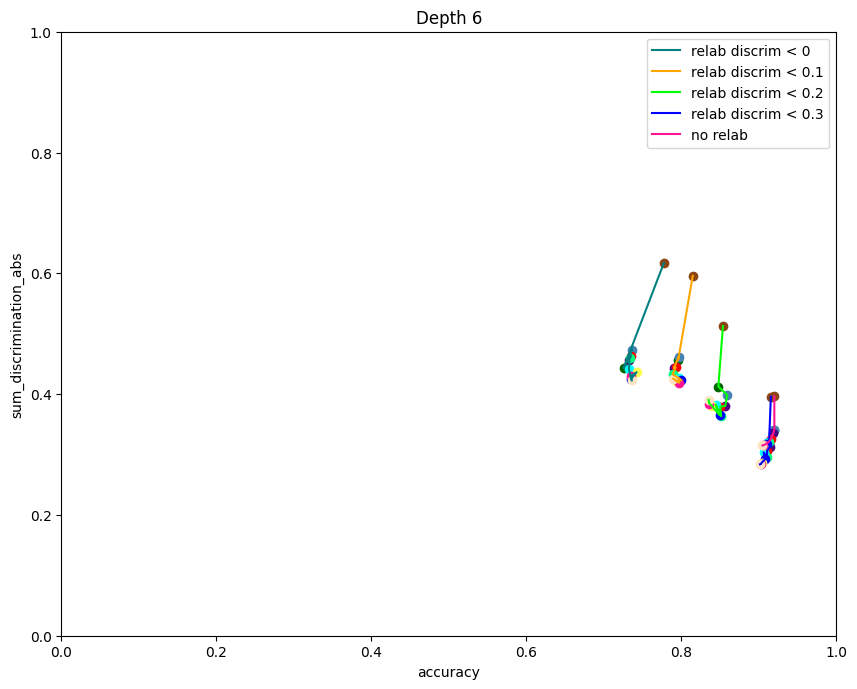

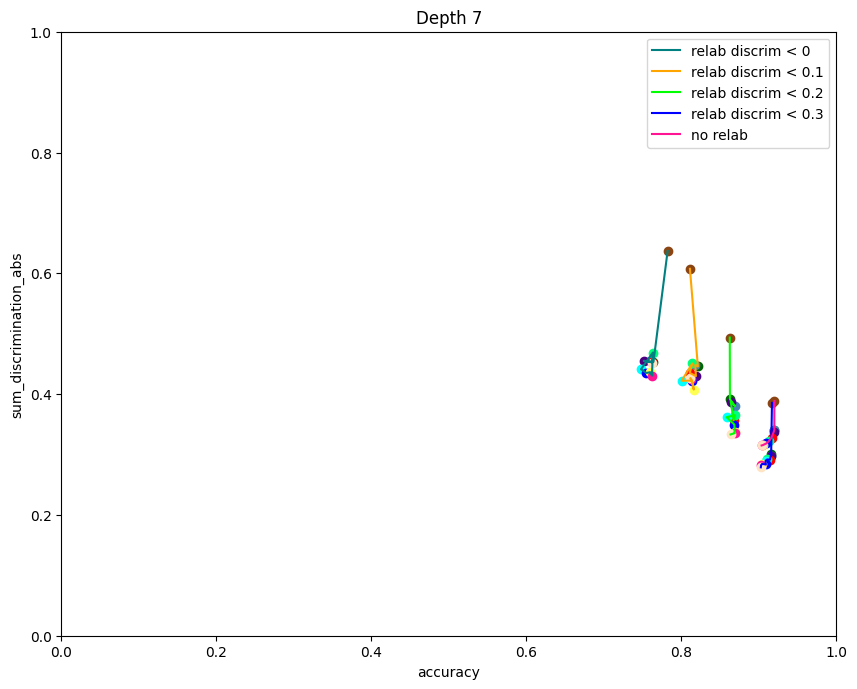

In [32]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_abs_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_abs_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_abs_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_abs_0.3'), ('accuracy_pred', 'sum_discrimination_additive_train_abs')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('accuracy')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()